In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

# Data science on responses to Automatique & Santé questionnaire
Action GDR MACS, Jérome Cieslak, Antoine Chaillet, JJ Aucouturier &copy; 2022

**Méthodologie:** 
- données récupérées de la déclaration d'intérêt, puis du questionnaire plus approfondi
- les questionnaires à choix multiples (ex. domaines cliniques = neurosciences, robotique chirurgicale, etc.) et à champ de réponse libre (ex. "principaux freins") sont re-encodés dans une nomenclature faite à la main, pour permettre de faire des histogrammes.
- les affiliations sont recodées en laboratoire, et géolocalisées par ville et département, pour affichage sur une carte
- les 2 questionnaires sont traités différemment, car listes choix multiples différentes, et les données sont fusionnées à la fin (note: le fichier de data manifestation_interet a été traité à la main par Antoine pour n'en garder que les entrées qui ne sont pas déjà dans le 2e questionnaire)

## Data from _Manifestation d'intérêt_ 

In [2]:
questions1_df = pd.read_csv('data/manifestation_interet.csv', encoding='latin1')

### Rename columns

In [3]:
questions1_df = questions1_df.rename(columns={'Horodateur':'date',
                                          'Quel est votre nom?':'last_name',
                                          'Quel est votre prénom?':'first_name', 
                                          'Si oui, dans quel domaine applicatif ? ':'clinical_domains',
                                          'Au travers de quels outils méthodologiques ?':'control_domains',
                                          'Si ces travaux ont déjà donné lieu à des publications, merci de nous en donner la liste:':'publication_list',
                                          'Sur le principe, seriez-vous intéressé par les actions suivantes (cette réponse ne constitue en rien un engagement de votre part!)':'interests',
                                          "Connaissez-vous des collègues (en France) dont les activités de recherche relèvent des outils de l'automatique utilisés pour la santé?":'recommendations',
                                          'Des suggestions ? Des remarques ?':'remarks'
                           })
questions1_df = questions1_df.drop(columns=['Avez-vous déjà travaillé sur des thématiques liant Automatique et Santé ou comptez-vous aborder de telles questions ?'])

In [49]:
# fix name formatting
questions1_df.first_name = questions1_df.first_name.str.capitalize()
questions1_df.last_name = questions1_df.last_name.str.capitalize()
questions1_df['respondent']=questions1_df['first_name']+" "+questions1_df['last_name']

### Parse categories from multiple-choice questions

#### Clinical domains

In [5]:
# split list in each column and explode as separate rows 
questions1_df.clinical_domains = questions1_df.clinical_domains.str.split(',')
questions1_df = questions1_df.explode('clinical_domains')

In [6]:
# rename duplicates: some values include white space or different accents
rename_clinical_domains = {'Neuroscience':'Neurosciences',
          'Système cardio-respiratoire':'Cardio-respiratoire',
          'Cancérologie':'Cancer',
          ' Anésthesie':'Anesthésie',
          ' Respiration artificielle':'Cardio-respiratoire',
          ' Diabète':'Diabète',
          ' Cancérologie':'Cancer',
          'Diabète':'Diabète',
          ' Système cardio-respiratoire':'Cardio-respiratoire',
          ' modélisation muscle':'Mouvement & Musculo-squelettique',
          ' Méditation':'Méditation',
          'Anesthésie':'Anesthésie'}
questions1_df.clinical_domains = questions1_df.clinical_domains.apply(lambda row: rename_clinical_domains[row])   


#### Control domains

In [7]:
# split list in each column and explode as separate rows 
questions1_df.control_domains = questions1_df.control_domains.str.split(',')
questions1_df = questions1_df.explode('control_domains')

In [8]:
# rename duplicates: white space and accents
rename_control_domains = {'Modélisation':'Modélisation',
                          ' Identification':'Identification',
                          'Identification':'Identification',
                          ' Commande':'Commande',
                          ' Observateurs':'Observateurs',
                          ' Analyse':'Analyse',
                          ' Traitement du signal ':'Traitement du signal',
                          'Observateurs':'Observateurs',
                          'Commande':'Commande',
                          'Analyse':'Analyse'}
questions1_df.control_domains = questions1_df.control_domains.apply(lambda row: rename_control_domains[row])   


#### Interests

In [9]:
# split list in each column and explode as separate rows 
questions1_df.interests = questions1_df.interests.str.replace(';',',') # some choices are semi-colon separated
questions1_df.interests = questions1_df.interests.str.split(',')
questions1_df = questions1_df.explode('interests')

In [10]:
# some values are split across different rows, as they include commas
# rename so each value is a separate category

DUPLICATE = "duplicate"

rename_interests = {"Etre informé par mail sur des actions scientifiques autour de l'Automatique et de la santé":'informé par email',
                    ' Participer à des journées scientifiques dédiées':'participer journées scientifiques',
       ' Contribuer à des publications communes (livre blanc': 'participer à des publications',
       ' vulgarisation':DUPLICATE,
        ' survey':DUPLICATE,
        ' conférences':DUPLICATE,
                    ' journaux':DUPLICATE,
                    '...)':DUPLICATE,
       " toute action facilitant l'accès à des practiciens hospitaliers pour conduire des tests cliniques": 'faciliter accès aux médecins',
       ' toute action permettant de trouver des étudiants candidats à stages de master et thèse sur la thématique. . ':'faciliter recrutement étudiants',
       ' Avoir accès à un site web recensant les activités sur ce thèmes':'site web dédié',
        ' Accès aux données':'faciliter accès aux données',
        ' créer une base de données pour échange':'faciliter accès aux médecins',
                    ' opportunités de collaborations aves des médecins':DUPLICATE,
                    ' avoir des subventions pour des stages de M2 ou pour des essais cliniques':'financements dédiés'}
questions1_df.interests = questions1_df.interests.apply(lambda row: rename_interests[row])   

# drop nans
questions1_df = questions1_df[~ (questions1_df.interests == DUPLICATE)]


## Data from _Questionnaire_ 

In [11]:
questions2_df = pd.read_csv('data/reponses_20_07_2022.csv', encoding='latin1')

In [12]:
# drop columns that are all na
questions2_df = questions2_df.dropna(axis='columns',how='all')

### Rename columns

In [13]:
# give clean names
questions2_df = questions2_df.rename(columns={'Horodateur':'date',
                                          'Quel est votre nom ?':'last_name',
                                          'Quel est votre prÃ©nom ?':'first_name', 
                                          'Quel est votre adresse mail?':'email',
                                          'Quel est votre statut?.2':'position',
                                          'Quel est votre employeur?':'employer',
                                          'Au travers de quels outils mÃ©thodologiques?':'control_domains',
                                          'Avec quel(le)s praticien(ne)s hospitalier(e)s (en France ou Ã\xa0 lâ\x80\x99Ã©tranger) travaillez-vous (service, hÃ´pital, adresse mail bienvenue) ?':'doctor_list',
                                          'Quel est votre laboratoire?':'affiliation',
                                          "Si oui, il s'agit de l'automatique pour?":'clinical_domains',
                                          'Au travers de quel type de financement?':'funding',
                                          'Si ces travaux ont dÃ©jÃ\xa0 donnÃ© lieu Ã\xa0 des publications, merci de nous en donner la liste:.1':'publication_list',
                                          'Seriez-vous intÃ©ressÃ© par les actions suivantes:.2':'interests',
                                          'Avec quels acteurs industriels (en France ou Ã\xa0 lâ\x80\x99Ã©tranger) travaillez-vous sur ces applications (nom, adresse mail bienvenue) ?':'industry_list',
                                          'Avec quel(le)s collÃ¨gues non automaticien(ne)s (en France ou Ã\xa0 lâ\x80\x99Ã©tranger) travaillez-vous (ou envisagez-vous de travailler) sur ces thÃ©matiques (nom, adresse mail bienvenue) ?':'non_control_collaborators',
                                          'Selon vous, quels sont les principaux freins Ã\xa0 une recherche interdisciplinaire mÃªlant automatique & santÃ© ?.3':'pain_points',
                                          'Selon vous, quels sont les acteurs majeurs (au niveau mondial) sur la recherche en Automatique au service de la santÃ© ?.1':'international_best',
                                          'Des suggestions ? Des remarques ?.1':'remarks'})
questions2_df = questions2_df.drop(columns=['Avez-vous dÃ©jÃ\xa0 travaillÃ© sur des thÃ©matiques liant Automatique et SantÃ© ou comptez-vous aborder de telles questions ?'])

In [50]:
# fix name formatting
questions2_df.first_name = questions2_df.first_name.str.capitalize()
questions2_df.last_name = questions2_df.last_name.str.capitalize()
questions2_df['respondent']=questions2_df['first_name']+" "+questions2_df['last_name']

### Fix duplicates

#### Position

In [15]:
questions2_df.position.unique()

array(['PU', 'Doctorant', 'MaÃ®tre de confÃ©rences', 'DR', 'Post-Doc',
       'DR Ã©mÃ©rite', 'CR', 'ITA (ex. IE, IR)', 'professeur',
       'PU Ã©mÃ©rite', 'Assistant Professor', 'Enseignant Chercheur',
       'Je ne connais pas son statut (enseignant-chercheur)',
       'IngÃ©nieur de recherche'], dtype=object)

In [16]:
# rename duplicates: some values include white space or different accents
rename_position = {'PU':'PU/Professor',
                   'Doctorant':'PhD student',
                   'MaÃ®tre de confÃ©rences':'MCU/Assistant Professor',
                   'DR':'Directeur de recherche',
                   'Post-Doc':'Postdoc',
                   'DR Ã©mÃ©rite':'Emeritus',
                   'CR':'Chargé de recherche',
                   'ITA (ex. IE, IR)':'Ingénieur Etude/Recherche',
                   'professeur':'PU/Professor',
                   'PU Ã©mÃ©rite':'Emeritus',
                   'Assistant Professor':'MCU/Assistant Professor', 
                   'Enseignant Chercheur':'MCU/Assistant Professor',
                   'Je ne connais pas son statut (enseignant-chercheur)':np.nan,
                   'IngÃ©nieur de recherche':'Ingénieur Etude/Recherche'}
questions2_df.position = questions2_df.position.apply(lambda row: rename_position[row]) 

#### Employer

In [17]:
questions2_df.employer.unique()

array(["Ecole d'ingÃ©nieurs CentraleSupÃ©lec", 'UniversitÃ©', 'CNRS',
       'CEGEDIM Groupe', 'Grenoble-INP', 'CentraleSupÃ©lec',
       'IRT Jules Verne', 'IMT Mines Ales', 'Centrale Nantes',
       'ENS Paris-Saclay', 'CHU 80% / Centrale 20%', 'Grand Ecole',
       'Bordeaux INP', 'ISAE-SUPAERO', 'ESTIA', 'INRIA', 'ENSMM',
       'ENSMM (SupMicroTech)', 'ONERA', 'ENSEA'], dtype=object)

In [18]:
# rename duplicates: 
rename_employer = {"Ecole d'ingÃ©nieurs CentraleSupÃ©lec": "Ecole d'ingénieur",
                   'UniversitÃ©':'Université',
                   'CNRS':'CNRS',
                   'CEGEDIM Groupe':'Industry',
                   'Grenoble-INP':"Ecole d'ingénieur",
                   'CentraleSupÃ©lec':"Ecole d'ingénieur",
                   'IRT Jules Verne':"Ecole d'ingénieur",
                   'IMT Mines Ales':"Ecole d'ingénieur",
                   'Centrale Nantes':"Ecole d'ingénieur",
                   'ENS Paris-Saclay':"Ecole d'ingénieur",
                   'CHU 80% / Centrale 20%':'Hospital',
                   'Grand Ecole':"Ecole d'ingénieur",
                   'Bordeaux INP':"Ecole d'ingénieur",
                   'ISAE-SUPAERO':"Ecole d'ingénieur",
                   'ESTIA':"Ecole d'ingénieur",
                   'INRIA':'INRIA',
                   'ENSMM':"Ecole d'ingénieur",
                   'ENSMM (SupMicroTech)':"Ecole d'ingénieur",
                   'ONERA':'ONERA',
                   'ENSEA':"Ecole d'ingénieur"}
questions2_df.employer = questions2_df.employer.apply(lambda row: rename_employer[row]) 

#### Affiliation

In [19]:
questions2_df.affiliation.unique()

array(['L2S', 'IMS Bordeaux', 'DISP', 'GIPSA-lab', 'CResTIC',
       'Laboratoire GÃ©nie et MatÃ©riaux Textiles (GEMTEX)',
       'LISSI EA 3956', 'LAMIH', 'gipsa-lab', 'LIS (Caen)', 'LIMOS',
       'IMS', 'LS2N UMR 6004 CNRS', 'AmpÃ¨re (UMR 5005)', 'CRAN', 'LS2N',
       'CERIS/PFM', 'LAMIH UMR CNRS 8201', 'ECN/LS2N UMR 6004', 'LURPA',
       'GIPSA-Lab', 'ESTAS', 'AmpÃ¨re UMR CNRS 5005', 'LAS2E',
       'LAS2E Enim Tunisie', 'Burlion Research L', 'ISAE-SUPAERO',
       'CRCA-CBI', 'LAAS-CNRS', 'ESTIA Recherche', 'IRIMAS', 'LIRYC',
       'Equipe SISTM, Inria Bordeaux, Inserm U1219', 'IETR', 'LJLL',
       'LAAS', 'FEMTO-ST', 'FEMTO-ST (AS2M department)', 'CRIStAL',
       'LAGEPP', 'UMR STMS', 'IDEES Le Havre CNRS 6266', 'ONERA/DTIS',
       'Institut FEMTO-ST', 'Quartz',
       "Laboratoire d'Automatique, SystÃ¨mes Ã\x89lectriques et Environnement (LAS2E) ENIM-Tunisie"],
      dtype=object)

In [20]:
# rename duplicates/common formatting: 
rename_affiliation = {'L2S':'Laboratoire des signaux et systèmes (L2S, UMR 8506)',
                      'IMS Bordeaux': 'Laboratoire de l’Intégration du Matériau au Système (IMS, UMR 5218)',
                      'DISP': 'Décision & Information pour les Systèmes de Production (DISP, UR 4570)',
                      'GIPSA-lab': 'Laboratoire Grenoble Images Parole Signal Automatique (GIPSA-Lab, UMR5216)',
                      'CResTIC':'Centre de Recherche en STIC (CReSTIC, EA 3804)',
                      'Laboratoire GÃ©nie et MatÃ©riaux Textiles (GEMTEX)': 'Laboratoire de génie et matériaux textiles (GEMTEX, EA 2461)',
                      'LISSI EA 3956':'Laboratoire Images, Signaux et Systèmes Intelligents (LISSI, EA 3956)',
                      'LAMIH':"Laboratoire d'Automatique de Mécanique et d'Informatique industrielles et Humaines (LAMIH, UMR 8201)",
                      'gipsa-lab':'Laboratoire Grenoble Images Parole Signal Automatique (GIPSA-Lab, UMR5216)',
                      'LIS (Caen)':"Laboratoire d'ingénierie des systèmes (LIS, UR 7478)",
                      'LIMOS':"Laboratoire d'Informatique, de Modélisation et d'Optimisation des Systèmes (LIMOS, UMR 6158)",
                      'IMS':'Laboratoire de l’Intégration du Matériau au Système (IMS, UMR 5218)',
                      'LS2N UMR 6004 CNRS':'Laboratoire des Sciences du Numérique de Nantes (LS2N, UMR6004)',
                      'AmpÃ¨re (UMR 5005)':'Laboratoire Ampère (UMR 5005)',
                      'CRAN':'Centre de Recherche en Automatique de Nancy (CRAN, UMR7039)',
                      'LS2N':'Laboratoire des Sciences du Numérique de Nantes (LS2N, UMR6004)',
                      'CERIS/PFM': "Centre d'Enseignement et de Recherche en Informatique et Systèmes (CERIS)",
                      'LAMIH UMR CNRS 8201': "Laboratoire d'Automatique de Mécanique et d'Informatique industrielles et Humaines (LAMIH, UMR 8201)",
                      'ECN/LS2N UMR 6004':'Laboratoire des Sciences du Numérique de Nantes (LS2N, UMR6004)',
                      'LURPA':'Laboratoire Universitaire de Recherche en Production Automatisée (LURPA, EA 1385)',
                      'GIPSA-Lab':'Laboratoire Grenoble Images Parole Signal Automatique (GIPSA-Lab, UMR5216)',
                      'ESTAS':"Institut français des sciences et technologies des transports, de l’aménagement et des réseaux (Ifsttar)",
                      'AmpÃ¨re UMR CNRS 5005':'Laboratoire Ampère (UMR 5005)',
                      'LAS2E':"Laboratoire d'Automatique, Systèmes Électriques et Environnement (LAS2E, Tunisie)",
                      'LAS2E Enim Tunisie':"Laboratoire d'Automatique, Systèmes Électriques et Environnement (LAS2E, Tunisie)",
                      'Burlion Research L':"Dept of Mechanical and Aerospace Engineering, Rutgers University",
                      'ISAE-SUPAERO':'Institut supérieur de l’aéronautique et de l’espace (ISAE-SUPAERO Recherche)',
                      'CRCA-CBI': "Centre de Recherches sur la Cognition Animale (CRCA, UMR 5169)",
                      'LAAS-CNRS': "Laboratoire d'analyse et d'architecture des systèmes (LAAS, UPR 8001)",
                      'ESTIA Recherche':"Ecole supérieure des technologies industrielles avancées (ESTIA Recherche)",
                      'IRIMAS':'Institut de Recherche en Informatique, Mathématiques, Automatique et Signal (IRIMAS, EA 7499)',
                      'LIRYC':'Institut De Rythmologie Et Modélisation Cardiaque (LIRYC, IHU)',
                      'Equipe SISTM, Inria Bordeaux, Inserm U1219': 'Centre de Recherche Inria Bordeaux - Sud-Ouest',
                      'IETR':"Institut d'Electronique et des Technologies du numéRique (IETR, UMR 6164)",
                      'LJLL':"Laboratoire Jacques-Louis Lions (LJLL, UMR 7598)",
                      'LAAS': "Laboratoire d'analyse et d'architecture des systèmes (LAAS, UPR 8001)",
                      'FEMTO-ST': "Franche-Comté Électronique Mécanique Thermique et Optique - Sciences et Technologies (FEMTO-ST, UMR 6174)",
                      'FEMTO-ST (AS2M department)':"Franche-Comté Électronique Mécanique Thermique et Optique - Sciences et Technologies (FEMTO-ST, UMR 6174)",
                      'CRIStAL':"Centre de Recherche en Informatique, Signal et Automatique de Lille (CRISTAL, UMR 9189)",
                      'LAGEPP':"Laboratoire d'Automatique et de Génie des Procédés (LAGEPP, UMR 5007)",
                      'UMR STMS': "Sciences et Technologies de la Musique et du Son (STMS, UMR 9912)",
                      'IDEES Le Havre CNRS 6266': "Identité et Différenciation de l'Espace, de l'Environnement et des Sociétés (IDEES, UMR 6266)",
                      'ONERA/DTIS': "Office national d'études et de recherches aérospatiales (ONERA)",
                      'Institut FEMTO-ST':"Franche-Comté Électronique Mécanique Thermique et Optique - Sciences et Technologies (FEMTO-ST, UMR 6174)",
                      'Quartz':"Laboratoire QUARTZ (EA 7393)",
                      "Laboratoire d'Automatique, SystÃ¨mes Ã\x89lectriques et Environnement (LAS2E) ENIM-Tunisie": "Laboratoire d'Automatique, Systèmes Électriques et Environnement (LAS2E, Tunisie)"}
questions2_df.affiliation = questions2_df.affiliation.apply(lambda row: rename_affiliation[row]) 

#### Add city for each lab

In [21]:
# rename duplicates/common formatting: 
lab_city = {'Laboratoire des signaux et systèmes (L2S, UMR 8506)':'91190, Gif-sur-Yvette',
            'Laboratoire de l’Intégration du Matériau au Système (IMS, UMR 5218)': "33400, Talence",
            'Décision & Information pour les Systèmes de Production (DISP, UR 4570)': "69621, Villeurbanne",
            'Laboratoire Grenoble Images Parole Signal Automatique (GIPSA-Lab, UMR5216)': "38400, Saint-Martin-d'Hères",
            'Centre de Recherche en STIC (CReSTIC, EA 3804)': "51100, Reims",
            'Laboratoire de génie et matériaux textiles (GEMTEX, EA 2461)': "59056, Roubaix",
            'Laboratoire Images, Signaux et Systèmes Intelligents (LISSI, EA 3956)':"94400, Vitry-sur-Seine",
            "Laboratoire d'Automatique de Mécanique et d'Informatique industrielles et Humaines (LAMIH, UMR 8201)":'59313, Valenciennes',
            "Laboratoire d'ingénierie des systèmes (LIS, UR 7478)": '14032, Caen',
            "Laboratoire d'Informatique, de Modélisation et d'Optimisation des Systèmes (LIMOS, UMR 6158)": '63178, Aubière',
            'Laboratoire des Sciences du Numérique de Nantes (LS2N, UMR6004)':'44322, Nantes',
            'Laboratoire Ampère (UMR 5005)':'69130, Écully',
            'Centre de Recherche en Automatique de Nancy (CRAN, UMR7039)':'54506, Vandoeuvre-lès-Nancy',
            "Centre d'Enseignement et de Recherche en Informatique et Systèmes (CERIS)":'30100, Alès',
            'Laboratoire Universitaire de Recherche en Production Automatisée (LURPA, EA 1385)': '91190, Gif-sur-Yvette',
            "Institut français des sciences et technologies des transports, de l’aménagement et des réseaux (Ifsttar)":"59666, Villeneuve d'Ascq",
            "Laboratoire d'Automatique, Systèmes Électriques et Environnement (LAS2E, Tunisie)": ", Monastir - Tunisia",
            "Dept of Mechanical and Aerospace Engineering, Rutgers University":", New Brunswick - NJ - USA",
            'Institut supérieur de l’aéronautique et de l’espace (ISAE-SUPAERO Recherche)': "31400, Toulouse",
            "Centre de Recherches sur la Cognition Animale (CRCA, UMR 5169)":"31400, Toulouse",
            "Laboratoire d'analyse et d'architecture des systèmes (LAAS, UPR 8001)": "31400, Toulouse",
            "Ecole supérieure des technologies industrielles avancées (ESTIA Recherche)": "64210, Bidart",
            'Institut de Recherche en Informatique, Mathématiques, Automatique et Signal (IRIMAS, EA 7499)':'68100, Mulhouse',
            'Institut De Rythmologie Et Modélisation Cardiaque (LIRYC, IHU)':'33600, Pessac',
            'Centre de Recherche Inria Bordeaux - Sud-Ouest':'33405, Talence',
            "Institut d'Electronique et des Technologies du numéRique (IETR, UMR 6164)": '35510, Cesson-Sévigné',
            "Laboratoire Jacques-Louis Lions (LJLL, UMR 7598)":"75005, Paris",
            "Franche-Comté Électronique Mécanique Thermique et Optique - Sciences et Technologies (FEMTO-ST, UMR 6174)":'25000, Besançon',
            "Centre de Recherche en Informatique, Signal et Automatique de Lille (CRISTAL, UMR 9189)":"59655, Villeneuve-d'Ascq",
            "Laboratoire d'Automatique et de Génie des Procédés (LAGEPP, UMR 5007)":"69622, Villeurbanne",
            "Sciences et Technologies de la Musique et du Son (STMS, UMR 9912)":'75004, Paris',
            "Identité et Différenciation de l'Espace, de l'Environnement et des Sociétés (IDEES, UMR 6266)":'76063, Le Havre',
            "Office national d'études et de recherches aérospatiales (ONERA)":"91120, Palaiseau",
            "Laboratoire QUARTZ (EA 7393)": "93400, Saint-Ouen-sur-Seine"}
questions2_df['city'] = questions2_df.affiliation.apply(lambda row: lab_city[row]) 

In [22]:
# split zip code from city 
questions2_df[["zip", "city"]] = questions2_df["city"].str.split(",", expand=True)
questions2_df.zip = questions2_df.zip.str[0:2]

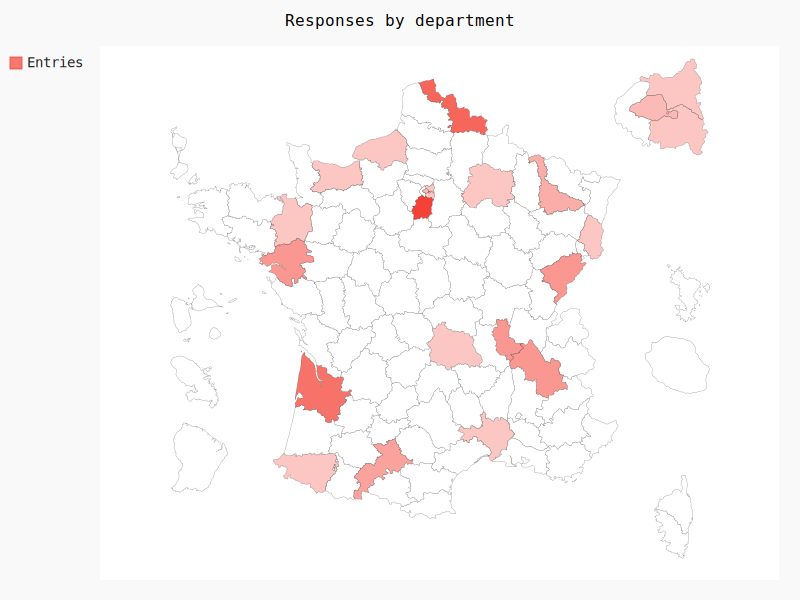

In [23]:
from pygal_maps_fr import maps
from IPython.display import SVG, display

dep = maps.Departments(human_readable=True)

dep.title = 'Responses by department'
dep.add('Entries', questions2_df.groupby(['zip']).last_name.nunique().to_dict())
#dep.render_to_file('map.svg')
display(SVG(dep.render(disable_xml_declaration=True)))


### Parse categories from multiple-choice questions

#### Clinical domains

In [24]:
# split list in each column and explode as separate rows 
questions2_df.clinical_domains = questions2_df.clinical_domains.str.split(',')
questions2_df= questions2_df.explode('clinical_domains')

In [25]:
# rename duplicates: some values include white space or different accents
rename_clinical_domains = {'Les neurosciences ou la psychatrie':'Neurosciences',
                           'Le systÃ¨me cardio-respiratoire (ex: respirateur artificiel)':'Cardio-respiratoire',
                           "L'Ã©pidÃ©miologie ou la santÃ© environnementale":'Epidémiologie & Infectiologie',
                           " l'organisation des systÃ¨mes des urgences":'Organisation des soins',
                           ' La cancÃ©rologie':'Cancer',
                           " L'anesthÃ©sie": 'Anesthésie',
                           'Le diabÃ¨te': 'Diabète',
                           'Les sciences du mouvement': 'Mouvement & Musculo-squelettique',
                           " L'Ã©pidÃ©miologie ou la santÃ© environnementale":'Epidémiologie',
                           ' pÃ©diatrie-maternitÃ©': 'Pédiatrie & Obstétrique', 
                           " La vision ou l'ophtalmologie": 'Ophtalmologie',
                           ' supply chain pharmaceutique': 'Pharmacaceutique',
                           ' gestion des patients': 'Organisation des soins',
                           ' Le systÃ¨me cardio-respiratoire (ex: respirateur artificiel)':'Cardio-respiratoire',
                           ' Les sciences du mouvement':'Mouvement & Musculo-squelettique',
                           ' La biochimie ou la biologie cellulaire Ã\xa0 visÃ©e translationnelle':'Biologie cellulaire',
                           ' Le diabÃ¨te': 'Diabète',
                           ' Les prothÃ¨ses':'Mouvement & Musculo-squelettique',
                           ' IngÃ©nierie et gestion es opÃ©rations de la production de soins': 'Organisation des soins',
                           'La cancÃ©rologie': 'Cancer',
                           ' infectiologie (VIH)': 'Epidémiologie & Infectiologie',
                           'simulation haptique pÃ©dagogique (accouchement': 'Robotique médicale & chirurgie', 
                           ' pÃ©ridurale':DUPLICATE, 
                           ' neurochir)':DUPLICATE, #multiple lines
                           'Exosquelette pour rÃ©Ã©ducation et les personnes Ã\xa0 mobilitÃ© rÃ©duite': 'Mouvement & Musculo-squelettique',
                           'ModÃ©lisation des habitudes de vie': DUPLICATE,
                           ' dÃ©tection des dÃ©viations de comportement':'Mouvement & Musculo-squelettique',
                           ' Localisation indoor': DUPLICATE,
                           " Estimation de l'attitude et role dans la classification de mouvement humain Ã\xa0 l'aide de capteurs inertiels et magnÃ©tiques": 'Mouvement & Musculo-squelettique',
                           "La vision ou l'ophtalmologie": 'Ophtalmologie',
                           " SystÃ¨mes d'aide Ã\xa0 la prise de dÃ©cision pour le diagnostic mÃ©dical": 'Organisation des soins',
                           "L'ORL ou l'audition": 'ORL',
                           ' La robotique biomÃ©dicale': 'Robotique médicale & Chirurgie',
                           'Optimisation des organisations hospitaliÃ¨res (GÃ©nie Industriel)': 'Organisation des soins',
                           'La robotique biomÃ©dicale': 'Robotique médicale & chirurgie',
                           "L'anesthÃ©sie": 'Anesthésie',
                           "Assistance Ã\xa0 l'humain (robotique de rÃ©Ã©ducation":  'Robotique médicale & chirurgie',
                           ' diagnostic automatisÃ©...) ':DUPLICATE, 
                           'rien':np.nan, 
                           ' Cardiologie':'Cardio-respiratoire',
                           'maladies infectieuses':'Epidémiologie & Infectiologie',
                           ' ModÃ©lisation muscle':'Mouvement & Musculo-squelettique',
                           ' MÃ©ditation':'Méditation',
                           'gestion des services':'Organisation des soins',
                           ' ThÃ©rapeutique': DUPLICATE,
                           ' Ethique MÃ©dical':'Ethique',
                           "apprentissage ML sur des EEG pour dÃ©tecter la Maladie de Parkinson et d'Alzheimer":'Neurosciences'}
questions2_df.clinical_domains = questions2_df.clinical_domains.apply(lambda row: rename_clinical_domains[row])   

questions2_df = questions2_df[~ (questions2_df.clinical_domains == DUPLICATE)]


#### Control domains

In [26]:
# split list in each column and explode as separate rows 
questions2_df.control_domains = questions2_df.control_domains.str.split(',')
questions2_df = questions2_df.explode('control_domains')

In [27]:
questions2_df.control_domains.unique()

array(['ModÃ©lisation', ' Analyse', ' Commande', ' Observateurs',
       ' Identification', 'Commande', ' capteurs souples',
       ' wearable system', ' systÃ¨me expert', ' optimisation',
       ' Apprentissage ', ' diagnostic', 'Observateurs',
       ' Filtres de kalman', ' IA et Softcomputing', ' Optimisation',
       ' Simulation et Intelligence Artificielle', 'Identification',
       ' optimisation multi-objectifs',
       "En tant que pÃ¨re d'une enfant diabÃ©tique de type 1",
       " je me suis intÃ©ressÃ© aux approches d'ingÃ©nieries et scientifiques sur le domaine",
       'rien', ' Traitement du signal', 'Analyse',
       ' Design and fabrication', ' Machine Learning'], dtype=object)

In [28]:
# rename duplicates: white space and accents
rename_control_domains = {'ModÃ©lisation':'Modélisation',
                          ' Analyse':'Analyse',
                          ' Commande':'Commande',
                          ' Observateurs':'Observateurs',
                          ' Identification':'Identification',
                          'Commande':'Commande',
                          ' capteurs souples':'Autre (capteurs)',
                          ' wearable system': 'Autre (capteurs)',
                          ' systÃ¨me expert': 'Autre (apprentissage machine / IA)',
                          ' optimisation': 'Autre (optimisation)',
                          ' Apprentissage ':'Autre (apprentissage machine / IA)',
                          ' diagnostic':'Autre (apprentissage machine / IA)',
                          'Observateurs':'Observateurs',
                          ' Filtres de kalman':'Modélisation',
                          ' IA et Softcomputing':'Autre (apprentissage machine / IA)',
                          ' Optimisation':'Autre (optimisation)',
                          ' Simulation et Intelligence Artificielle': 'Autre (apprentissage machine / IA)',
                          'Identification':'Identification',
                          ' optimisation multi-objectifs': 'Autre (optimisation)',
                          "En tant que pÃ¨re d'une enfant diabÃ©tique de type 1":np.nan,
                          " je me suis intÃ©ressÃ© aux approches d'ingÃ©nieries et scientifiques sur le domaine":DUPLICATE,
                          'rien':np.nan,
                          ' Traitement du signal':'Autre (traitement du signal)',
                          'Analyse':'Analyse',
                          ' Design and fabrication':'Autre (fabrication)',
                          ' Machine Learning':'Autre (apprentissage machine / IA)'}
questions2_df.control_domains = questions2_df.control_domains.apply(lambda row: rename_control_domains[row]) 

# remove duplicates
questions2_df = questions2_df[~ (questions2_df.control_domains == DUPLICATE)]

#### Interests

In [29]:
# split list in each column and explode as separate rows 
questions2_df.interests = questions2_df.interests.str.replace(';',',') # some choices are semi-colon separated
questions2_df.interests = questions2_df.interests.str.split(',')
questions2_df = questions2_df.explode('interests')

In [30]:
questions2_df.interests.unique()

array(["Etre informÃ© par mail sur des actions scientifiques autour de l'Automatique et de la SantÃ©",
       ' Avoir accÃ¨s Ã\xa0 un site web recensant les activitÃ©s sur ce thÃ¨me',
       ' Participer Ã\xa0 des journÃ©es scientifiques dÃ©diÃ©es',
       ' Contribuer Ã\xa0 des publications communes (livre blanc',
       ' vulgarisation', ' survey', ' confÃ©rences', ' journaux', '...)',
       'Participer Ã\xa0 des journÃ©es scientifiques dÃ©diÃ©es',
       'Avoir accÃ¨s Ã\xa0 un site web recensant les activitÃ©s sur ce thÃ¨me',
       " Animer des sessions sur l'apprentissage du geste mÃ©dical sur simulateur (haptique)",
       ' RÃ©alisation de CongrÃ¨s nationaux et internationaux ',
       ' AccÃ¨s aux donnÃ©es', ' crÃ©er une base',
       ' avoir des subventions pour des stages de M2 ou pour des essais cliniques',
       ' avoir des financements pour conf ou stage '], dtype=object)

In [31]:
# some values are split across different rows, as they include commas
# rename so each value is a separate category
rename_interests = {"Etre informÃ© par mail sur des actions scientifiques autour de l'Automatique et de la SantÃ©":'informé par email',
                    ' Participer Ã\xa0 des journÃ©es scientifiques dÃ©diÃ©es':'participer journées scientifiques',
                    'Participer Ã\xa0 des journÃ©es scientifiques dÃ©diÃ©es': 'participer journées scientifiques',
                    ' Contribuer Ã\xa0 des publications communes (livre blanc': 'participer à des publications',
                    ' vulgarisation':DUPLICATE, # multiple lines
                    ' survey':DUPLICATE,
                    ' confÃ©rences':DUPLICATE,
                    ' journaux':DUPLICATE,
                    '...)':DUPLICATE,
                    ' Avoir accÃ¨s Ã\xa0 un site web recensant les activitÃ©s sur ce thÃ¨me': 'site web dédié',
                    'Avoir accÃ¨s Ã\xa0 un site web recensant les activitÃ©s sur ce thÃ¨me': 'site web dédié',
                    " Animer des sessions sur l'apprentissage du geste mÃ©dical sur simulateur (haptique)":'participer journées scientifiques',
                    ' RÃ©alisation de CongrÃ¨s nationaux et internationaux ':'participer journées scientifiques',
                    ' AccÃ¨s aux donnÃ©es': 'faciliter accès aux données',
                    ' crÃ©er une base':'faciliter accès aux médecins',
                    ' avoir des subventions pour des stages de M2 ou pour des essais cliniques':'financements dédiés',
                    ' avoir des financements pour conf ou stage ':'financements dédiés'}
questions2_df.interests = questions2_df.interests.apply(lambda row: rename_interests[row])   


# remove duplicates
questions2_df = questions2_df[~ (questions2_df.interests == DUPLICATE)]

#### Pain points

In [32]:
# split list in each column and explode as separate rows 
questions2_df.pain_points = questions2_df.pain_points.str.split(r"\bet\b")
questions2_df= questions2_df.explode('pain_points')
questions2_df.pain_points = questions2_df.pain_points.str.split(',')
questions2_df= questions2_df.explode('pain_points')

In [33]:
questions2_df.pain_points.unique()

array(['Lourdeur administrative pour achat de matÃ©riel expÃ©rimental ',
       " l'utilisation des donnÃ©es", 'manque de financement',
       " manque d'ouverture d'esprit des journaux lors des publications",
       " mauvaises perpectives de carriÃ¨re aprÃ¨s (ah mais non t'est pas vraiment automaticien toi ...)",
       nan, 'les praticiens sont trÃ¨s sollicitÃ©s ',
       ' il est trÃ¨s difficile de caler une rÃ©union. ',
       'complexitÃ© des problÃ¨me', ' un grand Ã©cart dans les objectifs',
       ' ', ' les fonds', 'communication ',
       " mÃ©fiance Ã\xa0 l'Ã©gard de l'IA",
       'La taille des Ã©quipes travaillant sur ces sujets ',
       ' le manque de collaborations',
       'Ã©tablir une relation de confiance ', ' gagnant-gagnant',
       'ressources financiÃ¨res (financement doctorants + postdoc)',
       'acceptabilitÃ© des outils/mÃ©thodes par le monde mÃ©dical',
       "(i) difficultÃ©s des autorisations d'essais cliniques",
       ' protection des donnÃ©es',
      

In [34]:
# some values are split across different rows, as they include commas
# rename so each value is a separate category
rename_pain_points = {'Lourdeur administrative pour achat de matÃ©riel expÃ©rimental ':'difficulté pour achat matériel',
                      " l'utilisation des donnÃ©es": 'difficulté pour collecter ou accéder à des données sur patients',
                      'manque de financement': "manque de financement",
                      " manque d'ouverture d'esprit des journaux lors des publications": "difficulté pour publier (interdisciplinarité)",
                      " mauvaises perpectives de carriÃ¨re aprÃ¨s (ah mais non t'est pas vraiment automaticien toi ...)": "manque de reconnaissance par les tutelles (interdisciplinarité)",
                      'les praticiens sont trÃ¨s sollicitÃ©s ': "difficulté pour accéder aux médecins (manque de temps)",
                      ' il est trÃ¨s difficile de caler une rÃ©union. ': "difficulté pour accéder aux médecins (manque de temps)",
                      'complexitÃ© des problÃ¨me': 'complexité des problèmes/faible validité des résultats',
                      ' un grand Ã©cart dans les objectifs': 'complexité des problèmes/faible validité des résultats',
                      np.nan: np.nan, 
                      ' ':DUPLICATE,#multiple lines
                      ' les fonds':DUPLICATE,#multiple lines
                      'communication ':DUPLICATE,#multiple lines
                      " mÃ©fiance Ã\xa0 l'Ã©gard de l'IA": "difficulté pour accéder aux médecins (méfiance/acceptabilité des méthodes)",
                      'La taille des Ã©quipes travaillant sur ces sujets ': "petitesse de la communauté française",
                      ' le manque de collaborations': "difficulté pour accéder aux médecins (identifier/contacts)",
                      'Ã©tablir une relation de confiance ': "difficulté pour accéder aux médecins (méfiance/acceptabilité des méthodes)",
                      ' gagnant-gagnant':DUPLICATE, #multiple lines
                      'ressources financiÃ¨res (financement doctorants + postdoc)': "manque de financement",
                      'acceptabilitÃ© des outils/mÃ©thodes par le monde mÃ©dical': "difficulté pour accéder aux médecins (méfiance/acceptabilité des méthodes)",
                      "(i) difficultÃ©s des autorisations d'essais cliniques": 'difficulté pour collecter ou accéder à des données sur patients',
                      ' protection des donnÃ©es':DUPLICATE, #multiple lines
                      " avec un temps de rÃ©ponse >> durÃ©e de vie d'un doctorant (ii) relations peu fluides entre industriels ": "manque/difficulté valorisation industrielle",
                      ' rÃ©seau https://www.satt.fr/':DUPLICATE, #multiple lines
                      "L'absence d'industriels locaux pour valoriser.": "manque/difficulté valorisation industrielle",
                      "Les financements. Il est trÃ¨s difficile d'obtenir des financements en France.":"manque de financement",
                      'cultures diffÃ©rentes': "difficulté pour accéder aux médecins (se comprendre/culture différentes)",
                      'financement':"manque de financement",
                      ' comitÃ© Ã©thique': 'difficulté pour collecter ou accéder à des données sur patients',
                      'Essais expÃ©rimentaux': 'difficulté pour collecter ou accéder à des données sur patients',
                      ' manque de moyens/financements': "manque de financement",
                      ' manque de collaborations entre les automaticien(ne)s ':"difficulté pour accéder aux médecins (identifier/contacts)",
                      ' les praticien(ne)s hospitalier(e)s':DUPLICATE,
                      'difficultÃ© Ã\xa0 faire rencontrer scientifique & praticien dans de bonnes conditions pour parler "projet"': "difficulté pour accéder aux médecins (manque de temps)",
                      'DisponibilitÃ© des donnÃ©es': 'difficulté pour collecter ou accéder à des données sur patients',
                      ' manque de collaboration avec le personnel de santÃ©':"difficulté pour accéder aux médecins (identifier/contacts)",
                      ' manque de maturitÃ© sur les protocoles de validation ': 'complexité des problèmes/faible validité des résultats',
                      'financement...':"manque de financement",
                      'expÃ©rimentations':'difficulté pour collecter ou accéder à des données sur patients',
                      ' difficultÃ©s Ã\xa0 valoriser scientifiquement une expÃ©rimentation mÃªlant les deux spÃ©cialitÃ©s': "difficulté pour publier (interdisciplinarité)",
                      'rÃ©aliser les tests expÃ©rimentaux sur des sujets rÃ©els': 'difficulté pour collecter ou accéder à des données sur patients',
                      'Le manque de temps pour les cliniciens.': "difficulté pour accéder aux médecins (manque de temps)",
                      "L'utilisation des donnÃ©es des patients qui ne doivent pas Ãªtre divilgues": 'difficulté pour collecter ou accéder à des données sur patients',
                      'AccÃ¨s aux donnÃ©es': 'difficulté pour collecter ou accéder à des données sur patients',
                      ' faire des observation de terrain ': 'difficulté pour collecter ou accéder à des données sur patients',
                      ' accÃ©der Ã\xa0 des experts pour al validation des modÃ¨les. ':'complexité des problèmes/faible validité des résultats',
                      'manque de temps': "difficulté pour accéder aux médecins (manque de temps)",
                      'Manque de coopÃ©ration solide hospitalo-universitaire': "difficulté pour accéder aux médecins (identifier/contacts)",
                      'Manque de communication': "difficulté pour accéder aux médecins (se comprendre/culture différentes)",
                      'manque Ã©vident de communication venant des Ã©pidÃ©miologistes que je dÃ©plore': "difficulté pour accéder aux médecins (se comprendre/culture différentes)",
                      'peut Ãªtre la difficultÃ© Ã\xa0 identifier des Ã©coles doctorales Ã\xa0 spectre "large"': "manque de reconnaissance par les tutelles (interdisciplinarité)",
                      'la culture des deux disciplines diffÃ©rentes ': "difficulté pour accéder aux médecins (se comprendre/culture différentes)",
                      " le manque d'interaction entre les deux": "difficulté pour accéder aux médecins (identifier/contacts)",
                      'les liens avec les CHU - trouver des points de contacts. Et le pb que les mÃ©decins-anesthÃ©sistes ne soient pas toujours PUPH (donc dans une unitÃ© de recherche avec laquelle on peut monter un projet officiel':np.nan,
                      '1. Sur le diabÃ¨te':DUPLICATE,
                      ' Ãªtre capable de se comprendre entre spÃ©cialiste/chercheur du domaine mÃ©dical':"difficulté pour accéder aux médecins (se comprendre/culture différentes)",
                      " entre spÃ©cialiste de l'ingÃ©nierie/automatique":DUPLICATE,
                      ' comprendre les contraintes/usage) des malades atteints. 2. Quantifier ': 'difficulté pour collecter ou accéder à des données sur patients',
                      ' prioriser des actions de recherches ciblÃ©es sur les thÃ©rapies les plus prometteuses : cellule souches':"difficulté pour identifier les problèmes les plus porteurs",
                      ' pancrÃ©as bio artificiel':DUPLICATE,
                      ' pancrÃ©as artificiel (boucle fermÃ©e)':DUPLICATE,
                      "ConcrÃ©tement : la difficultÃ© d'accÃ¨s au patient":'difficulté pour collecter ou accéder à des données sur patients',
                      ' le travail en commun avec certains personnels de santÃ©':"difficulté pour accéder aux médecins (se comprendre/culture différentes)",
                      " la rÃ©alisation d'essais avec l'humain (problÃ¨me d'obtention d'autorisation d'essais CPP)":'difficulté pour collecter ou accéder à des données sur patients',
                      'AttractivitÃ© des applications afin de creer un catalyseur / temps Ã\xa0 dedier aux projets pluridisciplinaires':"manque/difficulté valorisation industrielle",
                      'The main obstacle is the development of the research ideal towards the path of commercialization which requires time of commitment and dedication. With the paradigm shift to continuum robotics':"manque/difficulté valorisation industrielle",
                      ' there are not enough research communities here in this domain France and this field definitely stands as the future of biomedical robotics for minimally invasive surgery.  ':"petitesse de la communauté française",
                      'la comprÃ©hension en terme linguistique':"difficulté pour accéder aux médecins (se comprendre/culture différentes)",
                      'le problÃ¨me de reconnaissance dans les revues pour du pluridisciplinaire ! ':"difficulté pour publier (interdisciplinarité)",
                      "Les problÃ¨mes d'Ã©thique doivent mieux Ãªtre pris en compte ainsi que la relation de soin ":"manque de considération pour l'éthique",
                      'Le volet essai clinique est sans doute le plus compliquÃ© Ã\xa0 apprÃ©hender':'difficulté pour collecter ou accéder à des données sur patients',
                      "L'aspect trÃ¨s disciplinaire du systÃ¨me acadÃ©mique franÃ§ais": "manque de reconnaissance par les tutelles (interdisciplinarité)",
                      "A l'ONERA":DUPLICATE,
                      " nous n'avons pas les contacts avec ni le milieu hospitalier ni les sociÃ©tÃ©s dans ce domaine. Ce qui est dommage":"difficulté pour accéder aux médecins (identifier/contacts)",
                      " car nos techniques servant dans l'aÃ©ronautique ":DUPLICATE,
                      " le spatial pourraient s'adapter Ã\xa0 des applications mÃ©dicales.":DUPLICATE,
                      'Financement':"manque de financement",
                      'Les questions qui prÃ©cÃ©dent rÃ©pondent Ã\xa0 cette question.':np.nan,
                      'Manque de contact':"difficulté pour accéder aux médecins (identifier/contacts)",
                      '  non existence de projets communs': DUPLICATE,
                      ' ...':DUPLICATE}
questions2_df.pain_points = questions2_df.pain_points.apply(lambda row: rename_pain_points[row])   

# remove duplicates
questions2_df = questions2_df[~ (questions2_df.pain_points == DUPLICATE)] 


## Merge questionnaires

### Check duplicates

En principe, la liste du questionnaire 1 ne devrait pas comprendre de personnes ayant également répondu au questionnaire 2. <mark> on voit ici que ce n'est pas le cas </mark> 

In [51]:
print("questionnaire 1 has %d respondents\nquestionnaire 2 has %d"%(questions1_df.respondent.nunique(),questions2_df.respondent.nunique()))

questionnaire 1 has 15 respondent
questionnaire 2 has 73


In [61]:
#nb de personnes du questionnaire 2 ayant déjà rempli le questionnaire 1
duplicate_respondents = questions2_df[questions2_df.respondent.isin(questions1_df.respondent.unique())].respondent.unique()
print('%d questions_1 respondents are also in questions_2:%s'%(len(duplicate_respondents),duplicate_respondents))

0 questions_1 respondents are also in questions_2:[]


In [58]:
# drop duplicates from questions1
duplicate_respondents = questions2_df[questions2_df.respondent.isin(questions1_df.respondent.unique())].respondent.unique()
questions1_df = questions1_df[~ questions1_df.respondent.isin(duplicate_respondents)]

In [63]:
# concat
questions_df = pd.concat([questions1_df,questions2_df], ignore_index=True)
print("merged questionnaire has %d respondents"%(questions_df.respondent.nunique()))

merged questionnaire has 77 respondents


### Add unique id per (first_name, last_name) pair

In [65]:
questions_df['respondent'] = pd.factorize(questions_df['respondent'])[0]

## Visualisation

### Positions

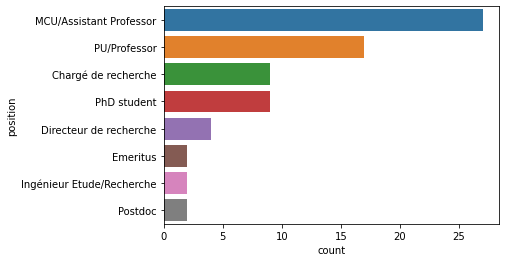

In [66]:
sns.countplot(y="position",
              order = questions_df.groupby(['position']).respondent.nunique().reset_index().sort_values(by='respondent',
                                                                                                     ascending=False).position,
              data=questions_df.drop_duplicates(subset=['respondent','position'], keep='first'))

### Employer

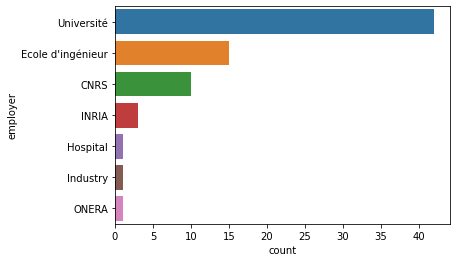

In [67]:
sns.countplot(y="employer",
              order = questions_df.groupby(['employer']).respondent.nunique().reset_index().sort_values(by='respondent',
                                                                                                     ascending=False).employer,
              data=questions_df.drop_duplicates(subset=['respondent','employer'], keep='first'))

### Labs

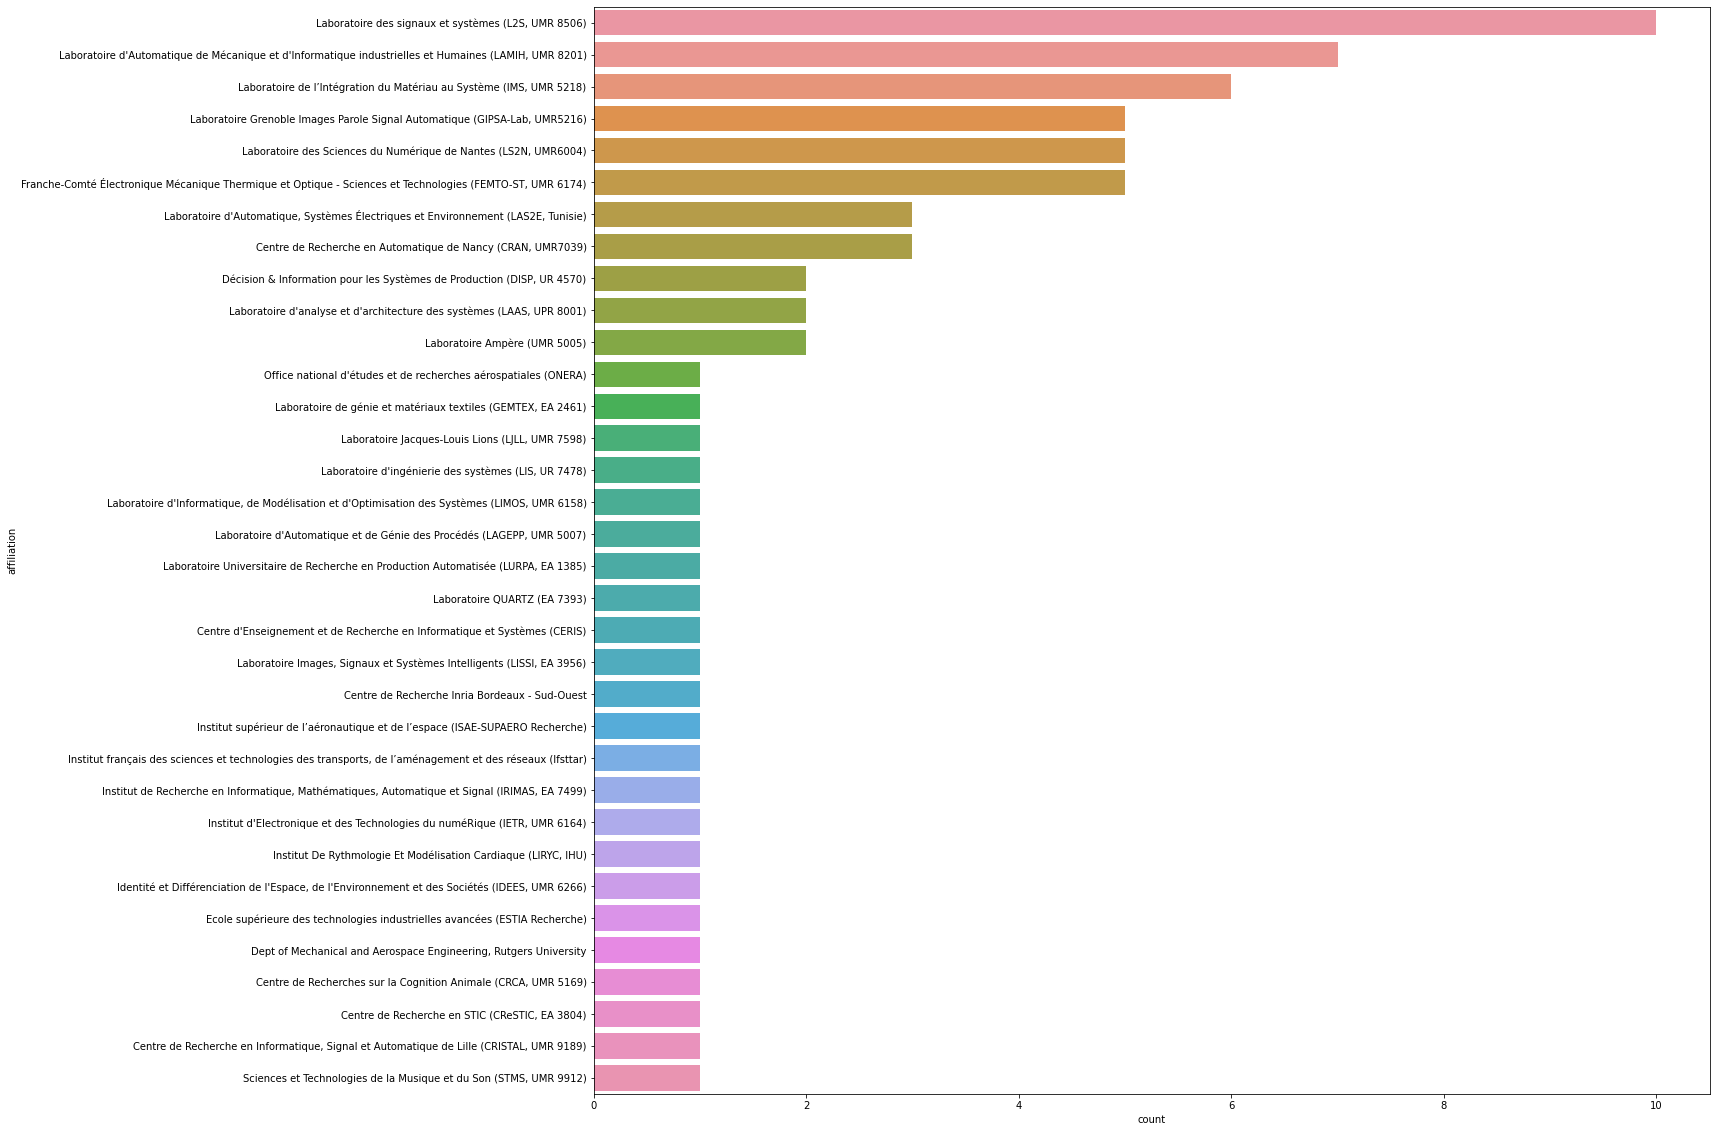

In [68]:
plt.figure(figsize=(20,20))
sns.countplot(y="affiliation",
              order = questions_df.groupby(['affiliation']).respondent.nunique().reset_index().sort_values(by='respondent',
                                                                                                     ascending=False).affiliation,
              data=questions_df.drop_duplicates(subset=['respondent','affiliation'], keep='first'))


### Cities

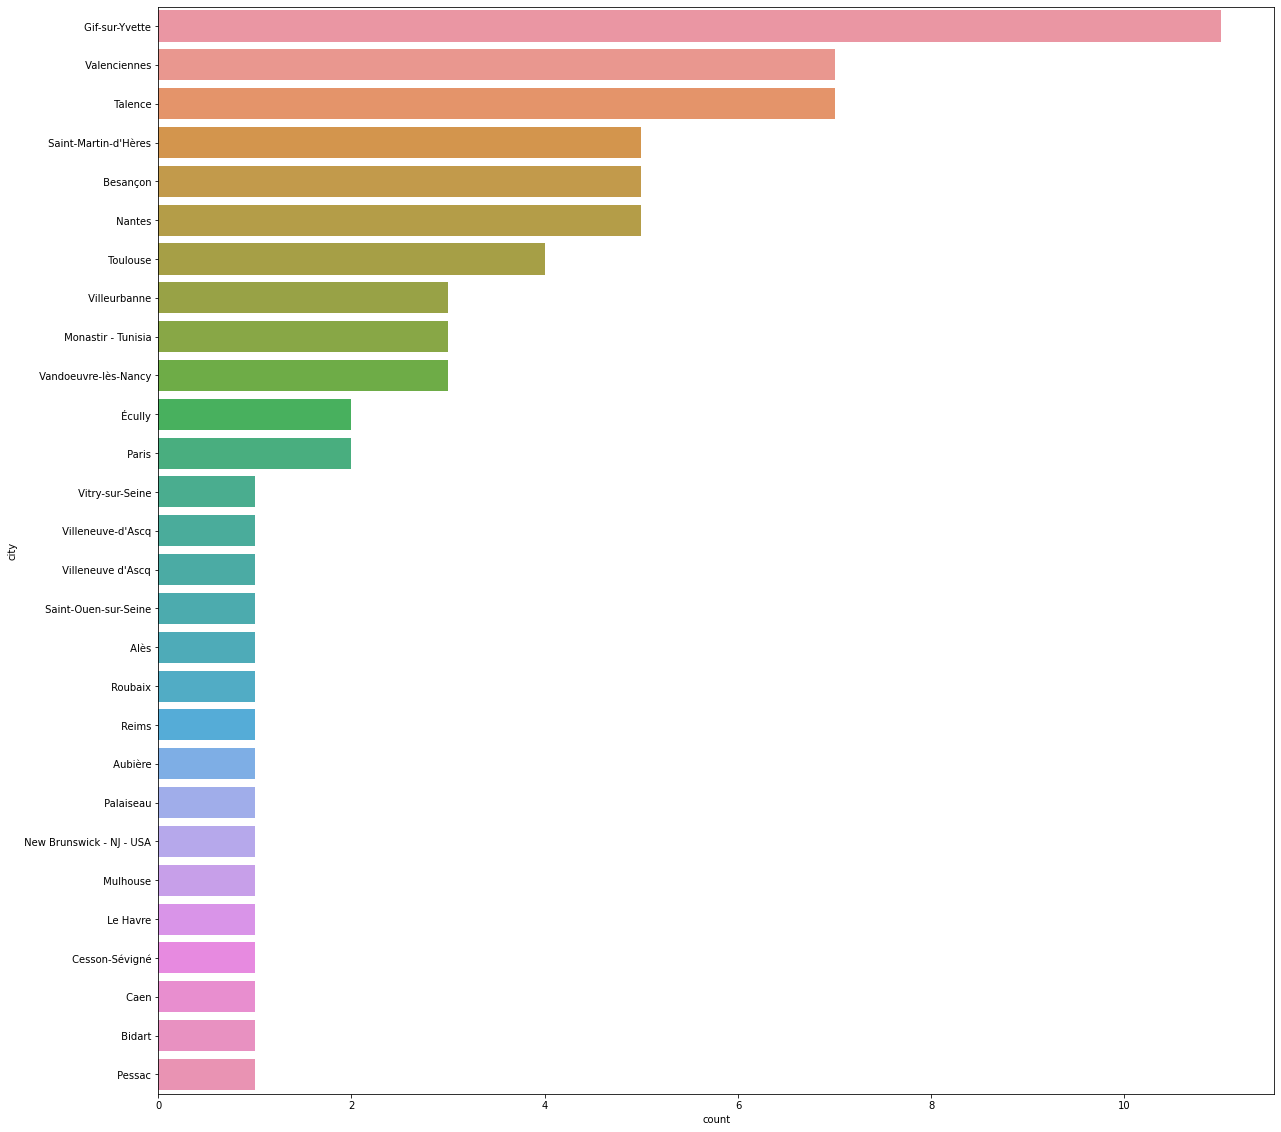

In [69]:
plt.figure(figsize=(20,20))
sns.countplot(y="city",
              order = questions_df.groupby(['city']).respondent.nunique().reset_index().sort_values(by='respondent',
                                                                                                     ascending=False).city,
              data=questions_df.drop_duplicates(subset=['respondent','city'], keep='first'))


<mark> issue: dropna in the multiple choice duplicates removes some otherwise perfectly good entries: less zip codes here than when tested before </mark>

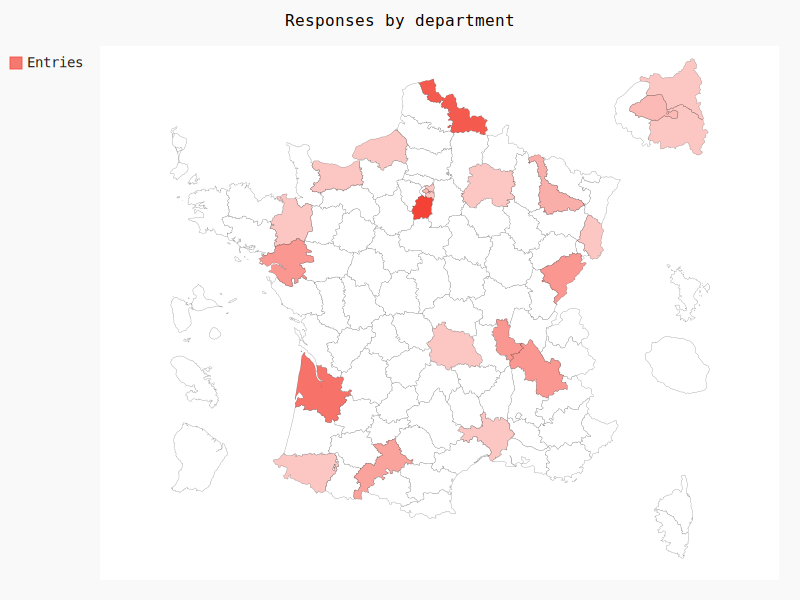

In [70]:
from pygal_maps_fr import maps
from IPython.display import SVG, display

dep = maps.Departments(human_readable=True)

dep.title = 'Responses by department'
dep.add('Entries', questions_df.groupby(['zip']).respondent.nunique().to_dict())
dep.render_to_file('map.svg')
display(SVG(dep.render(disable_xml_declaration=True)))


### Clinical domains

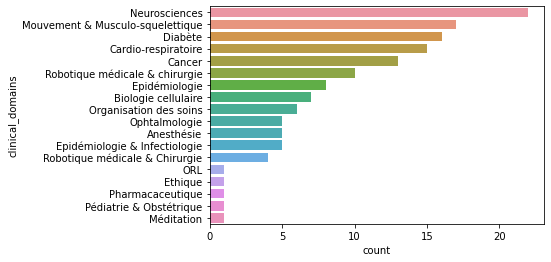

In [71]:
# count nb of unique last_name per domain 
# (removing duplicate entries for each last_name x domain, which correspond to distinct interests, methods etc.)
# and sort by decreasing count

sns.countplot(y="clinical_domains", 
              order = questions_df.groupby(['clinical_domains']).respondent.nunique().reset_index().sort_values(by='respondent',
                                                                                                     ascending=False).clinical_domains,
              
              data=questions_df.drop_duplicates(subset=['respondent','clinical_domains'], keep='first'))

### Control domains

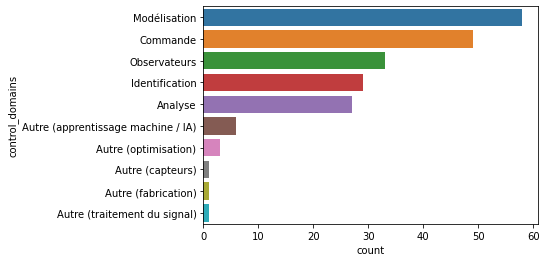

In [72]:
sns.countplot(y="control_domains", 
              order = questions_df.groupby(['control_domains']).respondent.nunique().reset_index().sort_values(by='respondent',
                                                                                                     ascending=False).control_domains,
              
              data=questions_df.drop_duplicates(subset=['respondent','control_domains'], keep='first'))

### Interests

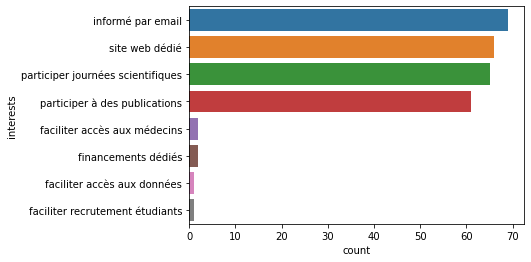

In [73]:
# count nb of unique last_name per interest 
# (removing duplicate entries for each last_name x interest, which correspond to distinct clinical domains and methods)
# and sort by decreasing count

sns.countplot(y="interests",
              order = questions_df.groupby(['interests']).respondent.nunique().reset_index().sort_values(by='respondent',
                                                                                                     ascending=False).interests,
              data=questions_df.drop_duplicates(subset=['respondent','interests'], keep='first')) 

### Pain points

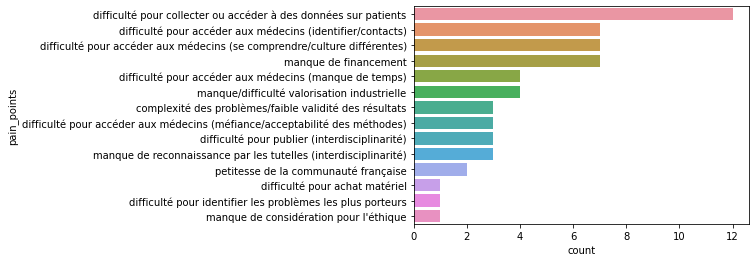

In [74]:
sns.countplot(y="pain_points",
              order = questions_df.groupby(['pain_points']).respondent.nunique().reset_index().sort_values(by='respondent',
                                                                                                     ascending=False).pain_points,
              data=questions_df.drop_duplicates(subset=['respondent','pain_points'], keep='first'))